# Modele partycjonujace

Jak działają modele partycjonujące?

- na początku wszystkie przypadki treningowe trafiają do jednego zbioru
- ocenianiny jest wpływ poszczególnych zmiennych wejściowych na podział tego zbioru względem zmiennej wyjściowej
- zbiór jest dzielony na podzbiory, aby każdy z tych podzbiorów zawierał jak najwięcej takich samych przypadków o takich samych wartościach zmiennej docelowej.
- dla każdego podzbioru następuje ponowna ocena zmiennych i ich dalszy podział

### Zalety modelów partycji

- są łatwe w interpretacji
- nie wymagają przyjęcia jakichkolwiek założeń dotyczących rozkładu danych i zależności między zmiennymi
- są niewrażliwe na wartości odstające

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
data = pd.read_csv("agaricus-lepiota.csv", delimiter=";")

Zasada działania modeli partycjonującyjch polega na podziale przypadków na podzbiory na podstawie tego, w jaki sposób ten podział wpłynie na stany zmiennej wyjściowej. Dlatego na początku należy sprawdzić rozkład zmiennej wyjściowej.

In [4]:
data["1"].value_counts(normalize=True) * 100

e    51.797144
p    48.202856
Name: 1, dtype: float64

### Analiza naszych danych

Poniżej pokazuje kilka cech które mogą mieć duże znaczenie na to czy grzyb jest jadalny czy też trujący.

black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y

Poniżej pokazany rozkład koloru skrzeli grzyba. Możemy wnioskować że jeżeli grzyb ma czerwony lub pomarańczowy kolor skrzeli to jest jadalny.

In [5]:
df1 = data[data["1"] == "p"]["10"].value_counts().rename("poisonus")
df2 = data[data["1"] == "e"]["10"].value_counts().rename("edible")
pd.concat([df1, df2], axis=1).replace(np.nan, 0)

,poisonus,edible
b,1728.0,0.0
p,640.0,852.0
h,528.0,204.0
g,504.0,248.0
w,246.0,956.0
n,112.0,936.0
k,64.0,344.0
u,48.0,444.0
r,24.0,0.0
y,22.0,64.0


stalk-color-above-ring:   brown=n,buff=b,cinnamon=c,gray=g,orange=o,
                                pink=p,red=e,white=w,yellow=y

Kolejna cecha która może być dość istotna to kolor łodygi nad pierścieniem.

In [6]:
df1 = data[data["1"] == "p"]["15"].value_counts().rename("poisonus")
df2 = data[data["1"] == "e"]["15"].value_counts().rename("edible")
pd.concat([df1, df2], axis=1).replace(np.nan, 0)

,poisonus,edible
w,1712.0,2752.0
p,1296.0,576.0
n,432.0,16.0
b,432.0,0.0
c,36.0,0.0
y,8.0,0.0
g,0.0,576.0
o,0.0,192.0
e,0.0,96.0


Im więkrza jest różnica między wykresami tym dana cecha bardziej wływa czy grzyb jest jadalny czy trujący.

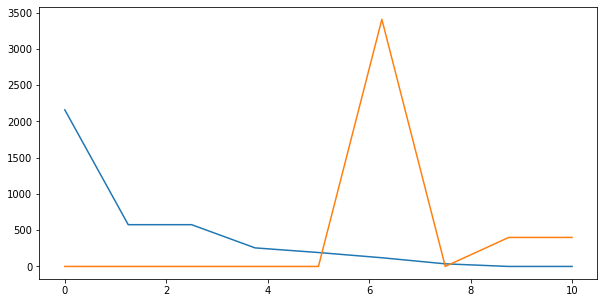

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

df1 = data[data["1"] == "p"]["6"].value_counts().rename("poisonus")
df2 = data[data["1"] == "e"]["6"].value_counts().rename("edible")
odor = pd.concat([df1, df2], axis=1).replace(np.nan, 0)

x = np.linspace(0, 10, len(odor["poisonus"]))
ax.plot(x, odor["poisonus"], x, odor["edible"])

### Przeprowadzamy test czy zmienna wejściowa (cecha grzyba) jest zależna od zmiennej wyjściowej (czy grzyb jest jadalny czy nie)

Dla sprawdzenia zależności między cechami grzybów a ich jadalnością możemy użyć testu zgodności chi-kwadrat. Polega on na porównaniu wartości zmierzonej (występowania jadalnych i trujących grzybów o danej cesze) z wartością oczekiwaną.
Następnie testem Pearsona sprawdzimy czy zależności między komórkami tabeli częstości jest statystycznie istotna.
Hipoteza zerowa zakłada ich niezależność, hipoteza alternatywna zakłada że komórki tabelo częstości zależą od siebie.


Wartości statystyczne należy obliczyć ze wzoru:

$$e_{ij} = \frac{r_i \times c_j}{t}$$

gdzie,
$r_i$ - to suma w i-tym wierszu
$c_j$ - to suma w j-tej kolumnie
$t$ - suma wszystkich elementów

In [8]:
myArray = np.array(pd.concat([df1, df2], axis=1).replace(np.nan, 0)).T

# Wyznaczamy tabele z wartościami oczekiwanymi
colSum = myArray.sum(axis=0) # Suma po kolumnach
rowSum = myArray.sum(axis=1) # Suma po wierszach
totalSum = myArray.sum() # Suma wszystkich komórek

eTable = np.zeros(myArray.shape)
rows, cols = eTable.shape

for i in range(rows):
    for j in range(cols):
        eTable[i][j] = rowSum[i] * colSum[j] / totalSum

eTable

array([[1041.1816839 ,  277.64844904,  277.64844904,  123.39931068,
          92.54948301, 1700.59675037,   17.35302806,  192.81142294,
         192.81142294],
       [1118.8183161 ,  298.35155096,  298.35155096,  132.60068932,
          99.45051699, 1827.40324963,   18.64697194,  207.18857706,
         207.18857706]])

Znając tabelę wartości oczekiwanej możemy obliczyć statystykę chi-kwadrat. Można ją policzyć ze wzoru:

$$X^2 = \sum \frac{(O - E)^2}{E}$$

gdzie,
$E$ - wartość oczekiwana
$O$ - wartość w oryginalnej tabeli

In [9]:
chisq_test = ((eTable - myArray)**2/eTable).sum()
chisq_test

7659.726740165338

Obliczoną wartość należy porównać z wartością z tablic statystycznych dla stopnia swobody obliczonego jako

$$df = (n_{rows} - 1) \times (n_{cols} - 1)$$

Jeżeli wartość odczytana jest mniejsza od testu chi-kwadrat to zmienne są zależne.

In [10]:
df = (rows - 1) * (cols - 1)
stats.chi2.ppf(0.05, df=8) # Wybieramy stopień istotności 0.05

2.732636793499662

## Ogólna idea drzew decyzyjnych

- Jeżeli zmienna jest numeryczna, zostaje ona poddana dyskretyzacji
- Ze zmiennych wejściowych wybierana jest ta, według której podział zminimalizuje ilość inforamcji potrzebnej do zaklasyfikowania przypadków względem zmiennej wyjściowej do otrzymanych w ten sposób podzbiorów.
- podzbiory są tworzone dla wszystkich stanów wybranej zmiennej lub metodą binarną, tak aby każdy podzbiór był maksymalnie jednorodny względem zmiennej wyjściowej od pozostałych podzbiorów.
- budowane są poddrzewa, których danymi treningowymi są otrzymane w poprzednim kroku podzbiory; jeżeli stosowna jest metoda wstępnego przycinania, poddrzewa, których podzbiory liczą zbyt mało przypadków lub dla których rozkład klas jest za mało wyraźny, są usuwane.

Kroki są powtarzane dla każdego poddrzewa, aż do wystąpienia jednej z sytuacji:

- wyczerpania przypadków w zbiorze treningowym
- przypisania wszystkich przypadków do jednej z klas
- przekroczenia zadanego czasu lub zadanej, maksymalnej wielkości drzew.

Budowanie drzewa decyzyjnego zaczyna się od znalezienia zmiennej, której podział wyznaczy korzeń drzewa. Do jej znalezienia można użyć różnych miar, na przykład entropii krzyżowej (cross entropy), prawdopodobieństwa Bayesa, zysku informacyjnego lub współczynnika Giniego. Wszystkie one wywodzą się z pojęcia entropii.

<img src="drzewo.gif"/>

# Entropia

Entropia jest miarą informacji. Przyjmuje ona maksimum, gdy prawdopodobieństwa wszystkich możliwych stanów są takie same, a minimum (0), prawdopodobieństwo jednego ze stanów wynosi 100%. Pokażemy to na przykładzie rzucania monetą. Pierwsza moneta będzie uczciwa, czyli przed rzutem prawdopodobieństwo, że wypadnie orzeł będzie takie same jak reszka. Przypuśćmy, że w serii 10 rzutów 6 razy wypadł orzeł, a 4 razy reszka. Entropia tej zmiennej jest duża, bliska maksymalnej.

Za drugim razem użyjemy fałszywej monety. Ponieważ ta moneta zawsze wypada orłem do góry to entropia jest minimalna.

Teraz policzymy entropię dla naszego zbioru. Checemy znaleźść zmienną która ma najmniejszą miarę entropii czyli ma najbardziej spodziewany wynik.

In [20]:
stats.entropy(data["6"].value_counts(), base=2)

2.3194144457106733

### Entropia, funkcja kosztu, optymalizacja uczenia maszynowego

Weźmiemy teraz pod uwagę dwie zmienne. Ich zysk informacyjny to ilość informacji, jaką zdobędziemy o stanie zmiennej B, jeżeli poznamy stan zmiennej A.
Innymi słowy zysk informacyjny jest ilością, jaka została usunięta z jednej zmiennej dzięki poznaniu wartości drugiej.

Entropia krzyżowa również pozwala zmierzyć redukcję entropii jednej zmiennej dzięki poznaniu wartości drugiej zmiennej tyle że wyraża ją w liczbie bitów potrzebnych do zakodowania zmiennych o nieznanych rozkładach.

Zauważmy że funkcja kosztu jest używana do oceny klasyfikacji wszystkich przykładów treningowych. Wyniki oceny poszczególnych przypadków się uśrednia. Uśredniając wyniki funkcji straty 0-1, otrzymamy funkcję, której wykres wygląda jak ramiona trójkąta - jej maksimum odpowiada najmniejszemu uporządkowaniu i zmniejsza się liniowo wraz ze zwiększaniem się prawdopodobieństw stanów 0 i 1. Natomiast pozostałe funkcje kosztu są funkcjami wklęsłymi, czyli łuk ich wykresów znajduje się powyżej cięciwy wyznaczonej wykresem funkcji straty 0-1.

Optymalizacja procesu uczenia daje najlepsze wyniki dla ciągłych, różniczkowalnych i wypukłych funkcji kosztu.

### Konstrukcja drzew decyzyjnych

Podział zmiennej może być zupełny lub binarny, na dwa podzbiory. Powyższe metody podziału nie mają zastosowania dla zmiennych numerycznych. Dlatego ich wartości są dynamicznie dzielone na równe podziały, oddzielenie dla każdego węzła drzewa decyzyjnego. Następnie sąsiednie przedziały są łączone, o ile takie połączenie daje możliwość lepszego podzielenia przypadków. Ten proces jest powtarzany aż do osiągnięcia przedziałów najlepiej nadających się do podzielenia przypadków w danym węźle drzewa decyzyjnego.